In [1]:
# module imports

import pandas as pd
import numpy
# import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

# import torch.nn.functional as F
# from torch.autograd import Variable
# from torch import nn, Tensor


from collections import Counter
from itertools import chain
import ast
import random
from datetime import datetime
from importlib import reload

# local imports

import BERT 
from BERT import BERT_model


from build_dataset import BertMobilityDataset, stratified_user_week_split, compute_rank_dict, torch_mask_tokens
from baseline_model import baseline_model
from train_model import train_loop, validation_loop, fit, NoamOpt


# For reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Load the data

In [3]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm

SEQUENCE_LENGTH = 50
BATCH_SIZE = 8
num_workers = 4
DATASET_PATH = "../data/final_data.csv"

# Function for setting seed (assuming it's defined)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# load data from csv
df = pd.read_csv(DATASET_PATH)

# split data into train, val, test
train_df, val_df, test_df = stratified_user_week_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15,ensure_user_in_all_sets=True)

# compute ranks for each user based on the train set
rank_dict = compute_rank_dict(train_df)

# create vocabulary based on the whole dataset
vocab = BertMobilityDataset(df,rank_dict).vocab 

# Initialize the datasets with the rank dictionary and vocabulary
train_dataset = BertMobilityDataset(train_df,rank_dict, vocab)
val_dataset = BertMobilityDataset(val_df, rank_dict, vocab)
test_dataset = BertMobilityDataset(test_df, rank_dict, vocab)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)

In [4]:
train_dataset.calculate_max_sequence_length(), val_dataset.calculate_max_sequence_length(), test_dataset.calculate_max_sequence_length()

(102, 101, 91)

In [5]:
len(train_df), len(val_df), len(test_df)

(159666, 34204, 34225)

In [6]:
test_dataset.calculate_avg_sequence_length(), val_dataset.calculate_avg_sequence_length(), test_dataset.calculate_avg_sequence_length()

(22.413228552717747, 22.65165562913907, 22.413228552717747)

## Train the model

In [7]:
import copy
def make_model(src_vocab,
               n_layers=6, 
               d_model=512,
               d_ff=2048, 
               n_heads=8, 
               dropout=0.1):
    
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = BERT.MultiHeadedAttention(n_heads, d_model)
    ff = BERT.PositionwiseFeedForward(d_model, d_ff, dropout)
    position = BERT.PositionalEncoding(d_model, dropout)
    
    vocab_sizes = [src_vocab, -1]
    emb_sizes = [40, 2]
    print('vocab_sizes', vocab_sizes)
    print('emb_sizes', emb_sizes)
    model = BERT_model(
        BERT.Encoder(BERT.EncoderLayer(d_model, c(attn), c(ff), dropout), n_layers),
        nn.Sequential(BERT.FusionEmbeddings(d_model, vocab_sizes, emb_sizes, device) , c(position)),
        # nn.Sequential(BERT.Embeddings(d_model, src_vocab), c(position)),
         d_model,src_vocab)
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [8]:
# device = torch.device('cpu') 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ntokens = train_dataset.vocab_size  # size of vocabulary
epochs = 50 
d_model = 40
d_hid = 40  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder --> 1
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0  # dropout probability --> start with 0
lr = 0.001  # learning rate
model = make_model(src_vocab=ntokens, 
                   n_layers=nlayers, 
                   d_model=d_model,
                   d_ff=d_hid,
                   n_heads=nhead,
                   dropout=dropout)

features = '_'.join([k for k in train_dataset[0].keys() if k != 'y' and k != 'user_week'])

# figure name
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M")
fig_name =  '_' + features + '_' + dt_string + '.png'


# increase the dimesion of the vector: d_model, d_hid --> can store more information
# d_hid: projection dimensions
            
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    
model.to(device)

#opt = NoamOpt(d_hid, 1, 4000, torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98))
measures = fit(model, opt, train_loader, val_loader, epochs, ntokens)
train_loss_list, validation_loss_list, baseline_loss_list, train_accuracy_list, val_accuracy_list, val_baseline_accuracy_list = measures


vocab_sizes [6781, -1]
emb_sizes [40, 2]


/tmp/ipykernel_944000/3361980426.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Training and validating model
------------------------- Epoch 1 -------------------------


KeyboardInterrupt: 

# To do: save the model

# Plot results

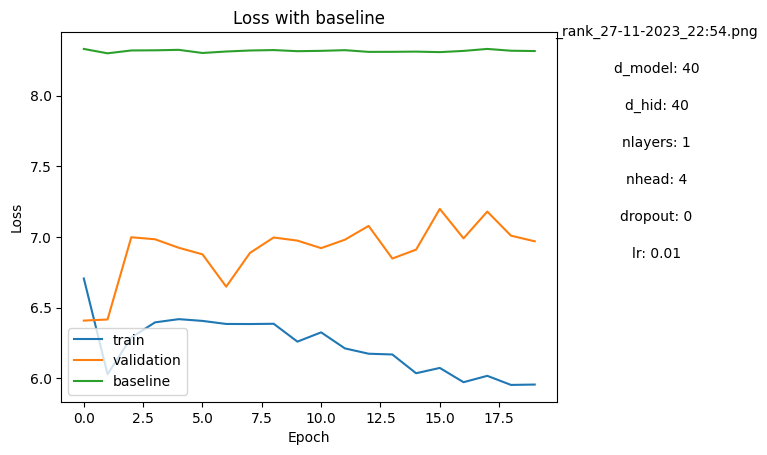

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(validation_loss_list)), validation_loss_list, label='validation')
plt.plot(np.arange(len(baseline_loss_list)), baseline_loss_list, label='baseline')

plt.title('Loss with baseline')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Add date to the plot
plt.text(1.2, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.text(1.2, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('./figures/loss_with_baseline' + fig_name, dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()


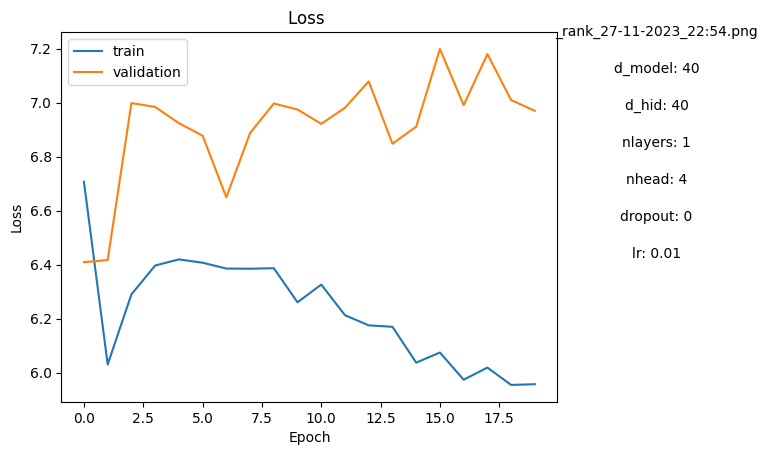

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(validation_loss_list)), validation_loss_list, label='validation')

plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Add date to the plot
plt.text(1.2, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.text(1.2, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('./figures/loss' + fig_name , dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()


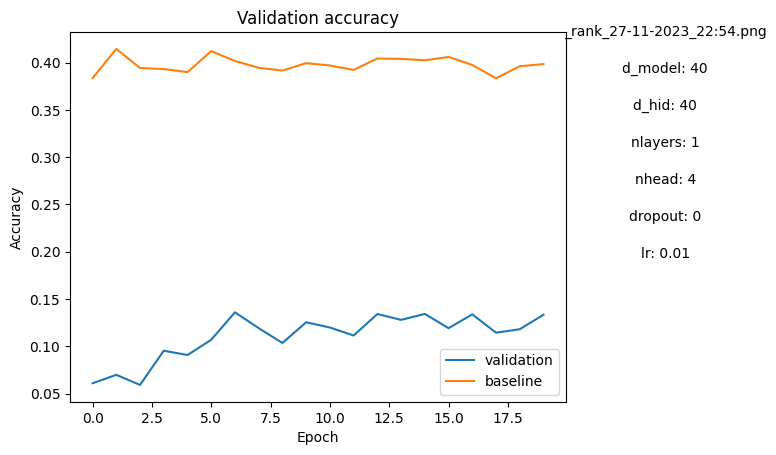

In [ ]:
from datetime import datetime

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
plt.plot(np.arange(len(val_accuracy_list)), val_accuracy_list, label='validation')
plt.plot(np.arange(len(val_baseline_accuracy_list)), val_baseline_accuracy_list, label='baseline')

plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Add date to the plot
plt.text(1.2, 1.0, fig_name, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.9, 'd_model: ' + str(d_model), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.8, 'd_hid: ' + str(d_hid), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.7, 'nlayers: ' + str(nlayers), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.6, 'nhead: ' + str(nhead), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.5, 'dropout: ' + str(dropout), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(1.2, 0.4, 'lr: ' + str(lr), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Save the plot
plt.savefig('../figures/accuracy' + fig_name, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



# Test the model

In [ ]:
def test_loop(model, dataloader, src_vocab):
    """
    This method performs evaluation on the test set.

    :param model: The model to be evaluated.
    :param dataloader: DataLoader for the test dataset.
    :param src_vocab: Source vocabulary size.
    """
    # Set the model to evaluation mode.
    model.eval()
    
    # Initialize variables for total loss and accuracy.
    total_test_loss = 0
    correct_predictions = 0
    total_predictions = 0
    predicted_labels_list, true_labels_list = [], []

    # Use torch.no_grad() for evaluation to reduce memory usage.
    with torch.no_grad():
        for X in dataloader:
            # Move tensors to the same device as the model.
            for k in X.keys():
                if k != 'user_week':
                    X[k] = X[k].to(device)

            # Extract features and masked tokens.
            features = [k for k in X.keys() if k != 'y' and k != 'user_week']
            masked_tokens, random_mask = torch_mask_tokens(X['y'], src_vocab)

            # Apply mask.
            for k in features:
                X[k][random_mask] = 0 

            # Prepare inputs for the model.
            y_input = [masked_tokens, *[X[k].view(X[k].size(0), X[k].size(1), -1).float() for k in features]]
            y_expected = X['y']

            # Create a mask for non-padded tokens.
            src_mask = ((X['y'] != 0).int()).to(device)
            src_mask = src_mask.unsqueeze(-1)

            # Get model predictions.
            pred = model(y_input, src_mask) # masked_tokens if without FusionEmbeddings otherwise y_input

            # Calculate loss.
            test_loss = masked_loss(pred, y_expected, random_mask)
            total_test_loss += test_loss.detach().item()

            # Calculate accuracy.
            y_predicted = torch.argmax(pred, dim=-1)
            true_labels = y_expected[random_mask]
            predicted_labels = y_predicted[random_mask]
            correct_predictions += (true_labels == predicted_labels).sum().item()
            total_predictions += true_labels.size(0)
            predicted_labels_list += predicted_labels.tolist()
            true_labels_list += true_labels.tolist()

    # Compute average loss and accuracy.
    avg_test_loss = total_test_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    # Log and return the results.
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_test_loss, accuracy, y_expected, y_predicted, true_labels_list, predicted_labels_list


In [ ]:
measures = test_loop(model, test_loader, ntokens)
avg_test_loss, accuracy, y_expected, y_predicted, true_labels_list, predicted_labels_list = measures

Test Loss: 6.2569, Test Accuracy: 0.1049


In [ ]:
def tensor_to_list(tensor):
    list_of_lists = []
    for row in tensor:
        # Convert to list and remove zeros
        list_without_padding = [x.item() for x in row if x not in (0, 1, 2, 3)]
        list_of_lists.append(list_without_padding)
    return list_of_lists

def decode_positions(indices, vocab):
    return [vocab[i] for i in indices]

In [ ]:
# Convert the tensor and remove padding
expected_trajecory = tensor_to_list(y_expected)
predicted_trajecory = tensor_to_list(y_predicted)

In [ ]:
predicted_positions = decode_positions(predicted_labels_list, vocab)
# calculate the frequency of the most common positions. round the values to 2 decimal places
pred_counter = Counter(predicted_positions)
total = sum(pred_counter.values())
for k, v in pred_counter.items():
    pred_counter[k] = round(v / total, 2)
    
true_positions = decode_positions(true_labels_list, vocab)
# calculate the frequency of the most common positions. round the values to 2 decimal places
true_counter = Counter(true_positions)
total = sum(true_counter.values())
for k, v in true_counter.items():
    true_counter[k] = round(v / total, 2)
    
vocab_freq = train_dataset.calculate_vocab_freq()
vocab_freq_list= list(vocab_freq.items())

# Sort and convert to lists
sorted_pred = sorted(pred_counter.items(), key=lambda x: x[1], reverse=True)
sorted_true = sorted(true_counter.items(), key=lambda x: x[1], reverse=True)
sorted_vocab_freq = sorted(vocab_freq_list, key=lambda x: x[1], reverse=True)

# Extract positions and frequencies into separate lists
pred_positions, pred_freq = zip(*sorted_pred)
true_positions, true_freq = zip(*sorted_true)
vocab_positions, vocab_freq = zip(*sorted_vocab_freq)

# Translate positions to labels
pred_labels = [vocab.index(str(pos)) for pos in pred_positions]
true_labels = [vocab.index(str(pos)) for pos in true_positions]
vocab_labels = [vocab.index(str(pos)) for pos in vocab_positions]

# Make sure all lists are of the same length for the DataFrame
min_length = min(len(pred_labels), len(true_labels), len(vocab_labels))
pred_labels, pred_freq = pred_labels[:min_length], pred_freq[:min_length]
true_labels, true_freq = true_labels[:min_length], true_freq[:min_length]
vocab_labels, vocab_freq = vocab_labels[:min_length], vocab_freq[:min_length]

# Create DataFrame
df_combined = pd.DataFrame({
    'Predicted Label': pred_labels,
    'Predicted Frequency': pred_freq,
    'True Label': true_labels,
    'True Frequency': true_freq,
    'Vocab Label': vocab_labels,
    'Vocab Frequency': vocab_freq
})



In [ ]:
df_combined.head(10)

,Predicted Label,Predicted Frequency,True Label,True Frequency,Vocab Label,Vocab Frequency
0,4,0.89,5,0.05,4,0.05
1,7,0.01,4,0.05,5,0.05
2,5,0.01,6,0.05,6,0.05
3,9,0.00,7,0.04,7,0.04
4,17,0.00,11,0.02,8,0.02
5,82,0.00,9,0.02,9,0.02
6,37,0.00,12,0.02,10,0.02
7,25,0.00,8,0.02,11,0.02
8,10,0.00,18,0.02,13,0.02
9,157,0.00,17,0.02,14,0.02


In [ ]:
import folium
import numpy as np

def plot_trajectory(binned_coords, lat_bins, lon_bins):
    # Convert string coordinates to tuples
    coord_tuples = [eval(coord) for coord in binned_coords]

    # Convert bin numbers to center points of the bins
    center_points = []
    for lat_bin, lon_bin in coord_tuples:
        lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
        lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
        center_points.append((lat_center, lon_center))

    # Create Folium map centered on the first point
    m = folium.Map(location=center_points[0], zoom_start=12)

    # Add points to the map
    folium.PolyLine(center_points, color="blue", weight=2.5, opacity=1).add_to(m)

    return m



In [ ]:
import folium
import numpy as np

def plot_multiple_trajectories(list_of_trajectories, lat_bins, lon_bins):
    # Predefined colors for different trajectories
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'lightgreen', 'gray', 'darkred', 'lightblue']

    # Initialize map; center on the first point of the first trajectory
    if list_of_trajectories:
        first_coord = eval(list_of_trajectories[0][0])
        lat_center = (lat_bins[first_coord[0] - 1] + lat_bins[first_coord[0]]) / 2
        lon_center = (lon_bins[first_coord[1] - 1] + lon_bins[first_coord[1]]) / 2
        m = folium.Map(location=(lat_center, lon_center), zoom_start=12)
    else:
        return "No trajectories provided"

    # Process and plot each trajectory
    for idx, trajectory in enumerate(list_of_trajectories):
        color = colors[idx % len(colors)]  # Cycle through colors

        # Convert string coordinates to tuples and then to center points
        coord_tuples = [eval(coord) for coord in trajectory]
        center_points = []
        for lat_bin, lon_bin in coord_tuples:
            lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
            lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
            center_points.append((lat_center, lon_center))

        # Add trajectory to the map
        folium.PolyLine(center_points, color=color, weight=2.5, opacity=1).add_to(m)

    return m


In [ ]:
# Example usage
lat_bins = np.linspace(55.52217281782121, 55.88796262687908, 200)
lon_bins = np.linspace(11.987848798727102, 12.734717261629013, 200)

In [ ]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in expected_trajecory], lat_bins, lon_bins)

In [ ]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in predicted_trajecory], lat_bins, lon_bins)

In [ ]:
# find index with the highest probability in pred
y_predicted = torch.argmax(pred, dim=-1)

In [ ]:
i=6
input_features = [int(t.item()) for t in y_input[1][i]]
masked_tokens = [int(t.item()) for t in y_input[0][i]]
source_mask = [int(t.item()) for t in src_mask[i]]
expected = [int(t.item()) for t in y_expected[i]]
predicted = [int(t.item()) for t in y_predicted[i]]

print("src_mask\n", source_mask, "\ninput features \n", input_features, "\nmasked tokens\n", masked_tokens)
print("\nexpected\n", expected, "\npredicted\n", predicted)
print("random_mask", random_mask[i])

NameError: name 'y_input' is not defined